# Upload model with pretrained weights

In [0]:
!pip install librosa

In [0]:
!pip install --upgrade efficientnet-pytorch

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-cp36-none-any.whl size=12422 sha256=2a1c6809aca696998629a790be546f049fc1a99cb09d0716db6ffd9b3992eee7
  Stored in directory: /root/.cache/pip/wheels/42/1e/a9/2a578ba9ad04e776e80bf0f70d8a7f4c29ec0718b92d8f6ccd
Successfully built efficientnet-pytorch


In [0]:
from google.colab import files
files.upload()

Saving model.pt to model.pt


In [0]:
import numpy as np
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
import librosa
import matplotlib.pyplot as plt

from efficientnet_pytorch import EfficientNet
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.transforms import transforms
import cv2

# from waves to spectrograms
def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

In [0]:
# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=11)
model = model.to(device)
model.load_state_dict(torch.load('model.pt', map_location='cpu'))
model.eval()

# Record audio

In [0]:
#https://gist.github.com/korakot/c21c3476c024ad6d56d5f48b0bca92be
# all imports
from IPython.display import Javascript
from google.colab import output
from base64 import b64decode
from io import BytesIO
!pip -q install pydub
from pydub import AudioSegment
import time

RECORD = """
const sleep  = time => new Promise(resolve => setTimeout(resolve, time))
const b2text = blob => new Promise(resolve => {
  const reader = new FileReader()
  reader.onloadend = e => resolve(e.srcElement.result)
  reader.readAsDataURL(blob)
})
var record = time => new Promise(async resolve => {
  stream = await navigator.mediaDevices.getUserMedia({ audio: true })
  recorder = new MediaRecorder(stream)
  chunks = []
  recorder.ondataavailable = e => chunks.push(e.data)
  recorder.start()
  await sleep(time)
  recorder.onstop = async ()=>{
    blob = new Blob(chunks)
    text = await b2text(blob)
    resolve(text)
  }
  recorder.stop()
})
"""

def record(sec=1, path_to_save= "/content/"):
  display(Javascript(RECORD))
  s = output.eval_js('record(%d)' % (sec*1000))
  b = b64decode(s.split(',')[1])
  audio = AudioSegment.from_file(BytesIO(b))
  fn = str(time.time()) + ".wav"
  audio.export(path_to_save + fn, format="wav")
  return fn, audio

In [0]:
filename, play = record()
print(filename); play


<IPython.core.display.Javascript object>

1586970269.0568466.wav


# Prediction

tensor([[-6.5697, -1.1030, -3.4726,  3.9975, -5.2163,  2.9905, -5.3554,  0.6309,
         -1.7225, -4.9554,  2.8240]], grad_fn=<AddmmBackward>)
up


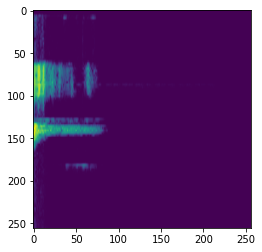

In [0]:
# Get prediction
labels = ["go", "off", "stop", "up", "no", "right", "down", "left", "on", "yes", "bed"]

path_to_file = "/content/" + filename
samples, sample_rate = librosa.load(path_to_file, mono=True, sr=None)
freqs, times, spectrogram = log_specgram(samples, sample_rate)
img = cv2.resize(spectrogram, (256, 256))
img_rgb = np.stack((img,)*3, axis=-1).astype(np.float32())
plt.imshow(img)

aug = transforms.Compose([transforms.ToTensor(),
                          transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                             ])

new_tensor = aug(img_rgb)


output = model(new_tensor.unsqueeze(0).to(device))
print(output)
_, prediction = torch.max(output.data, 1)
print(labels[int(prediction)])
play